In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os, os.path
import re
import glob
import pickle
import numpy
import tqdm
import corner
from scipy.misc import logsumexp
from scipy import interpolate
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.actionAngle import actionAngleTorus
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles
import seaborn as sns
import MWPotential2014Likelihood
import pal5_util
import mcmc_pal5
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0
%pylab inline
from matplotlib import cm
import copy
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Exploration of the Milky Way's dark halo shape using the Palomar 5 stream

## The data

In [2]:
pos_radec, rvel_ra= pal5_util.pal5_data()

## Some convenience functions

In [3]:
width_trailing= pal5_util.width_trailing

In [4]:
def plot_data_add_labels(radeconly=False,rvonly=False,color=sns.color_palette()[2]):
    if not radeconly and not rvonly: subplot(1,2,1)
    if not rvonly:
        xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
        ylabel(r'$\mathrm{Dec}\,(\mathrm{degree})$')
        xlim(250.,220.)
        ylim(-5.,9.)
        bovy_plot._add_ticks()
        errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
                 ls='none',marker='o',color=color)
    if radeconly: return None
    if not rvonly: subplot(1,2,2)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$')
    xlim(250.,220.)
    ylim(-80.,0.)
    bovy_plot._add_ticks()
    errorbar(rvel_ra[rvel_ra[:,0] > 230.5,0],rvel_ra[rvel_ra[:,0] > 230.5,1],
             yerr=rvel_ra[rvel_ra[:,0] > 230.5,2],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## The fiducial model

The fiducial model assumes a spherical halo, with the best-fit parameters from fitting to the MWPotential2014 data

In [6]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.0,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
aAT= actionAngleTorus(pot=pot,tol=0.001)
sigv= 0.4

In [7]:
sdf_trailing= streamdf(sigv/vo,progenitor=prog,
                       pot=pot,aA=aAI,useTM=aAT,
                       approxConstTrackFreq=True,
                       leading=False,nTrackChunks=21,
                       tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                       ro=ro,vo=vo,R0=ro,
                       vsun=[-11.1,vo+24.,7.25],
                       custom_transform=pal5_util._TPAL5)
sdf_leading= streamdf(sigv/vo,progenitor=prog,
                      pot=pot,aA=aAI,useTM=aAT,
                      approxConstTrackFreq=True,
                      leading=True,nTrackChunks=21,
                      tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                      ro=ro,vo=vo,R0=ro,
                      vsun=[-11.1,vo+24.,7.25],
                      custom_transform=pal5_util._TPAL5)

In [8]:
threshold= 0.3
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True,coord='customra',threshold=threshold)\
    +sdf_trailing.length(ang=True,coord='customra',threshold=threshold),
     sdf_leading.length(ang=True,coord='customra',threshold=threshold),
     sdf_trailing.length(ang=True,coord='customra',threshold=threshold))
#print "Angular width (FWHM): %f arcmin" % (width_trailing(sdf_trailing))

Angular length: 71.069607 deg (leading,trailing)=(43.798465,27.271142) deg


In [9]:
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

What is the observed length?

In [10]:
# Pretend to find the length
peak_dens= sdf_trailing.density_par(0.1,coord='customra')
trackxieta_trailing=\
    pal5_util.radec_to_pal5xieta(trackRADec_trailing[:,0],
                                 trackRADec_trailing[:,1],degree=True)
theta_end= numpy.interp(15.,trackxieta_trailing[:,0],
                    sdf_trailing._interpolatedThetasTrack)
end_dens= sdf_trailing.density_par(theta_end,coord='customra')
print "Pal 5's trailing tail is at least %.1f degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree" \
    % sdf_trailing.length(threshold=end_dens/peak_dens,coord='customra',ang=True)

Pal 5's trailing tail is at least 21.3 degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree


<Container object of 3 artists>

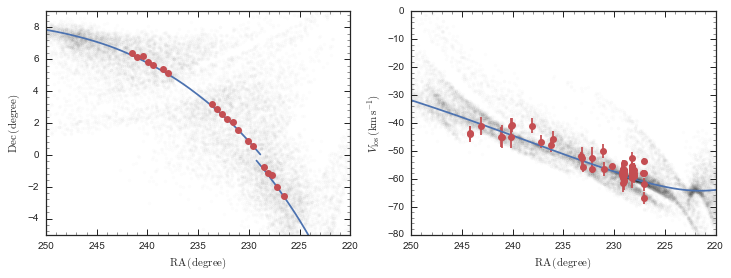

In [11]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

The wide scatter in the black dots is because the TM calculation of the track does not do the spread well.

## The orbit of Pal 5 in different flattened and triaxial potentials

In [12]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

In [13]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

Vary $c$ along the best-fit line:

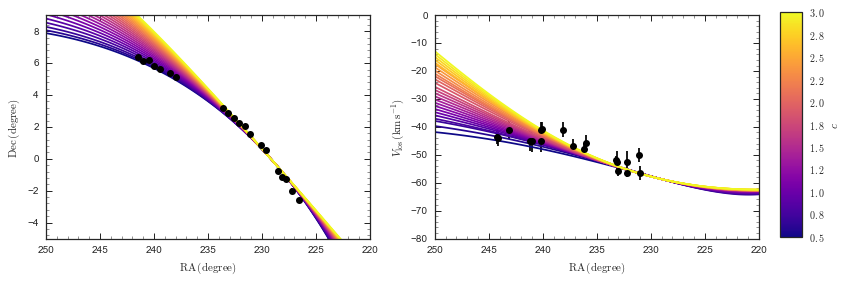

In [14]:
figsize(12,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,3.,r'$c$',save_figures=False)

Vary $b$ for $c=1$ (pa=0):

In [15]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

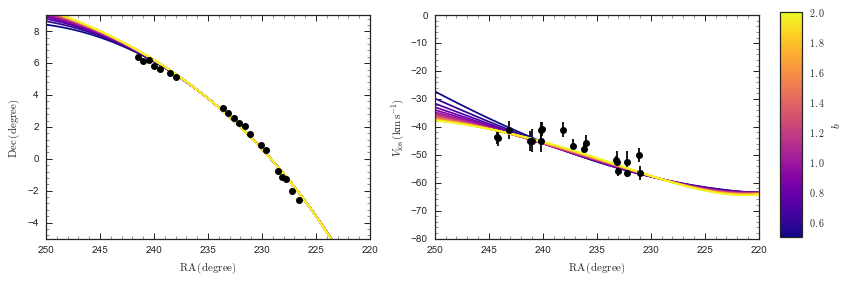

In [16]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary $b$ for $c=1$ (pa=45 degree):

In [17]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b,pa=numpy.pi/4.)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

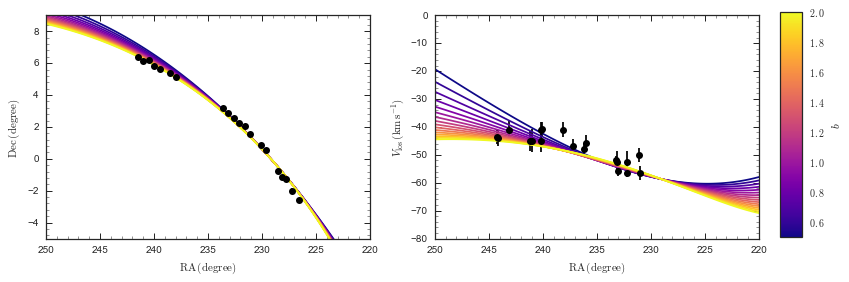

In [18]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary the distance:

In [19]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
ds= numpy.linspace(22.5,24.5,101)
for d in ds:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

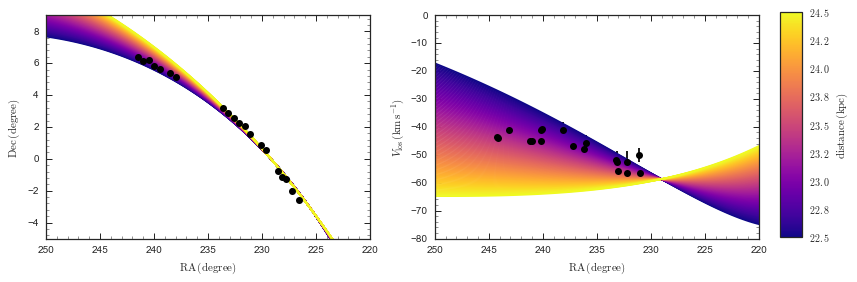

In [20]:
figsize(12,4)
cmap= cm.plasma
for d,orb,orbf in zip(ds,progs,progfs):
    tc= cmap((d-numpy.amin(ds))/(numpy.amax(ds)-numpy.amin(ds)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(ds),numpy.amax(ds),r'$\mathrm{distance}\,(\mathrm{kpc})$',save_figures=False)

Vary the proper motion parallel to the stream:

In [21]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

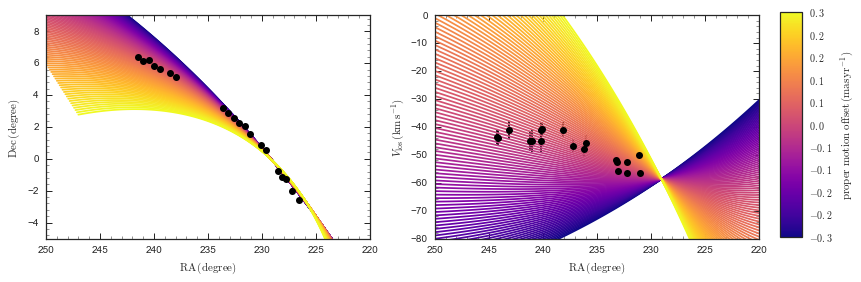

In [22]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

Vary the proper motion perpendicular to the stream:

In [23]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

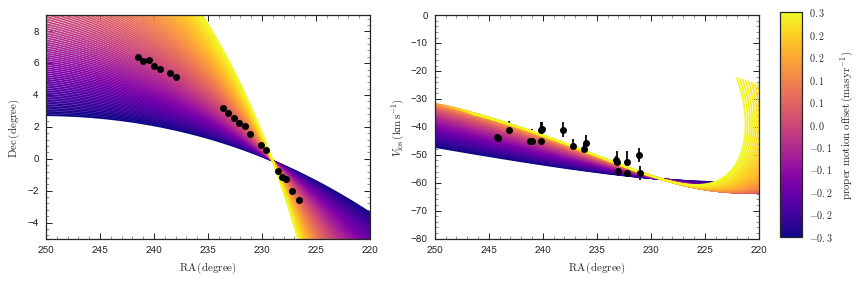

In [24]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

## How does the track, width, and length of the Pal 5 stream vary with the potential?

We compute the stream structure for a fiducial set of parameters, to get a sense of where the track lies and how the width and length vary

In [25]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=1,useTM=False,
                                         interpcs=cs[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

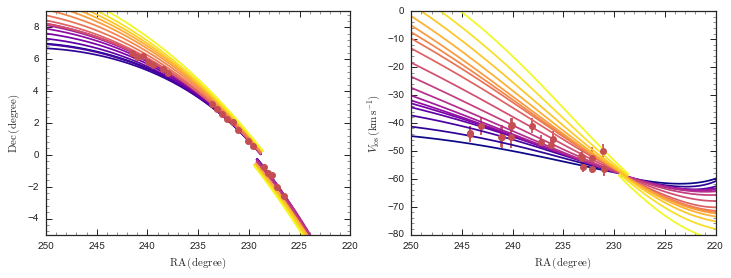

In [26]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()

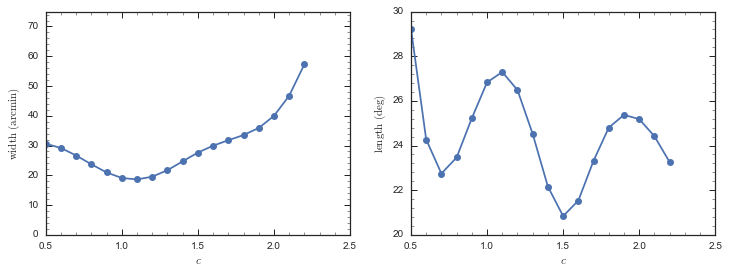

In [27]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Let's now try to make all streams 18' wide and 25 degree long:

In [28]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-constwl.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_constwl= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    interpcs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    ipw= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[4],k=3)
    ipl= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[5],k=3)
    sigv=0.4*18./ipw(interpcs)
    td=5.*25./ipl(interpcs)/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_constwl= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                                 interpcs=interpcs,
                                                 sigv=sigv,td=td,useTM=False)
    save_pickles(savefilename,cs,pal5varyc_constwl)

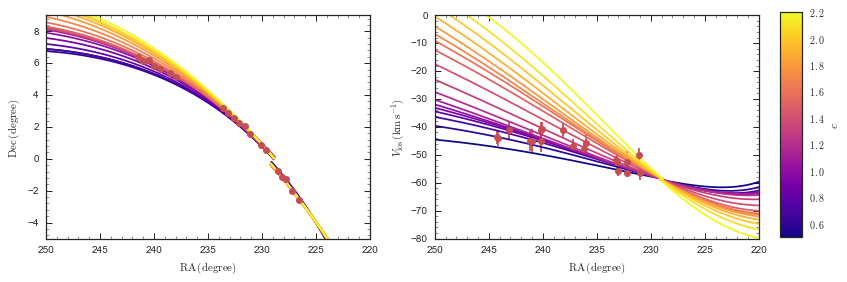

In [29]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Directly compare a subset ($c=0.5$ to $2.1$ in $0.2$ increments):

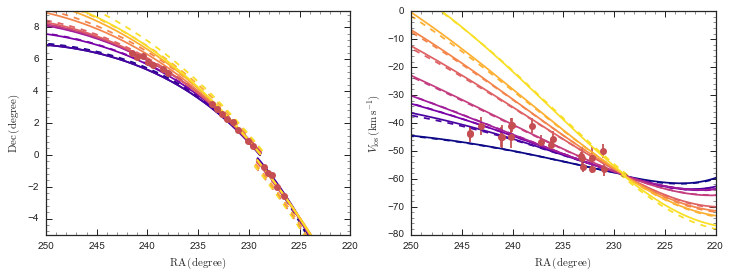

In [30]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs[::2]):
    ii*= 2
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
plot_data_add_labels()

The differences are small, especially around $c\approx1$. The width and length of the stream, pre-correction in green:

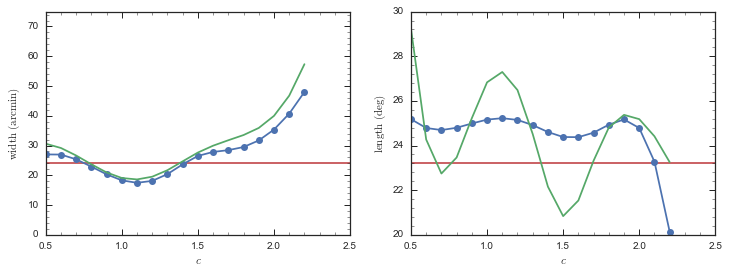

In [31]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

It appears that the increase in the stream age undoes the effect of making the stream colder on the width of the stream. This raises the question whether it is at all possible to have a long, cold stream in these $c\neq1$ potentials.

A test with double the number of track points, to see whether that matters. It does not:

In [32]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-ntc16.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=16,nTrackChunks=16,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

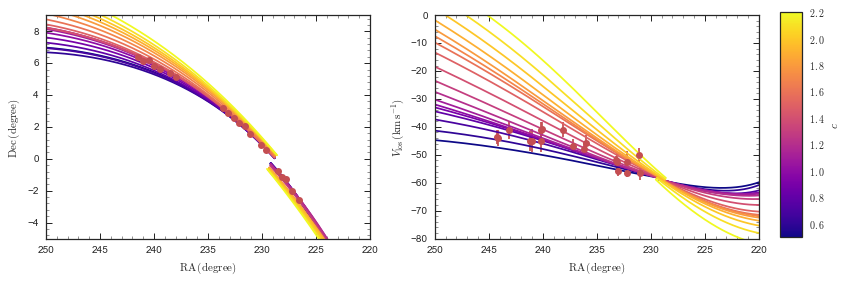

In [33]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Let's take a look at the grid-points themselves, to see whether the same trend shows for them. They do:

In [34]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-singlec.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.55,1.75,2.,2.25])
    trackRADec_trailing_out= numpy.empty((len(cs),1001,2))
    trackRADec_leading_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_trailing_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_leading_out= numpy.empty((len(cs),1001,2))
    width_out= numpy.empty(len(cs))
    length_out= numpy.empty(len(cs))
    for ii,c in enumerate(cs):
        tpal5varyc= pal5_util.predict_pal5obs(p_b15,c,multi=8,singlec=True)
        trackRADec_trailing_out[ii]= tpal5varyc[0]
        trackRADec_leading_out[ii]= tpal5varyc[1]
        trackRAVlos_trailing_out[ii]= tpal5varyc[2]
        trackRAVlos_leading_out[ii]= tpal5varyc[3]
        width_out[ii]= tpal5varyc[4]
        length_out[ii]= tpal5varyc[5]
    pal5varyc= (trackRADec_trailing_out,trackRADec_leading_out,
                trackRAVlos_trailing_out,trackRAVlos_leading_out,
                width_out,length_out)
    save_pickles(savefilename,cs,pal5varyc)

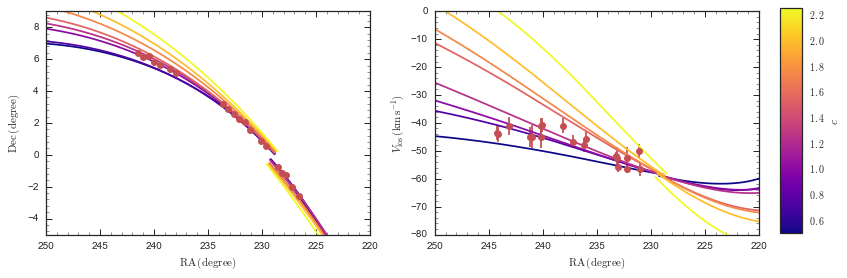

In [35]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

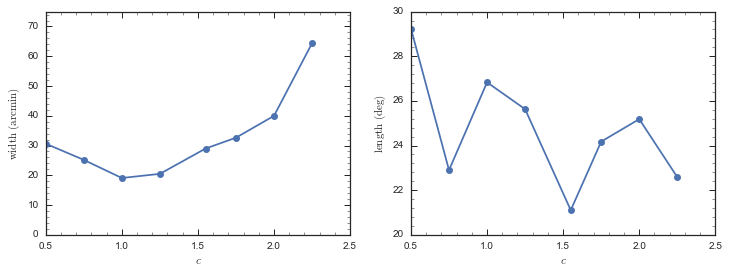

In [36]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

What happens when we use a denser interpolation grid?

In [37]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-densergrid.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.05)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.5,1.6,1.7,1.8,1.9,2.,2.1,2.2])
    save_pickles(savefilename,cs,pal5varyc)

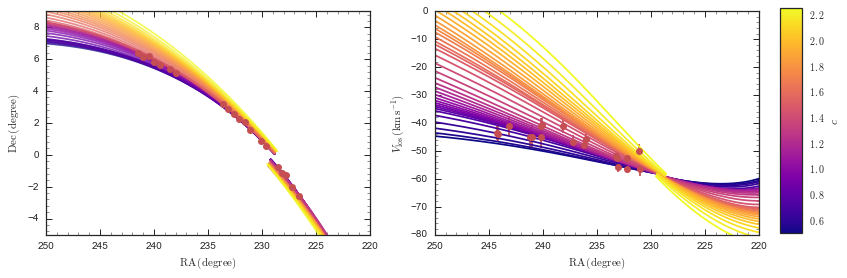

In [38]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

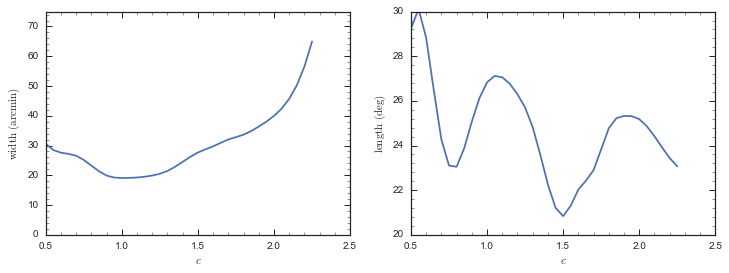

In [39]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Does this change for different potential parameters?

In [40]:
p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-shortscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

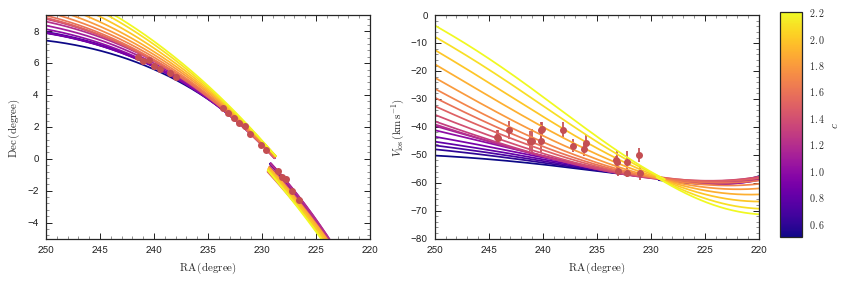

In [41]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < .95 or (c > 1.05 and c < 1.25): continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

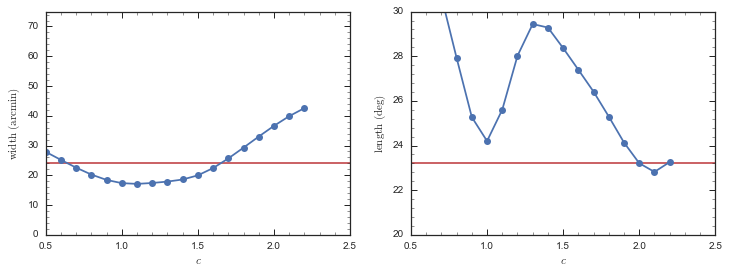

In [42]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another different potential:

In [43]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-longscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

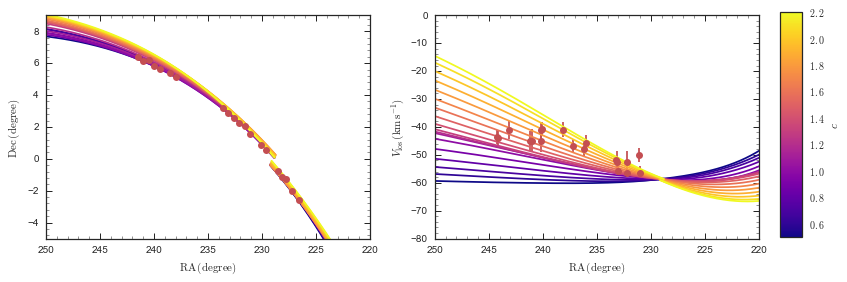

In [44]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

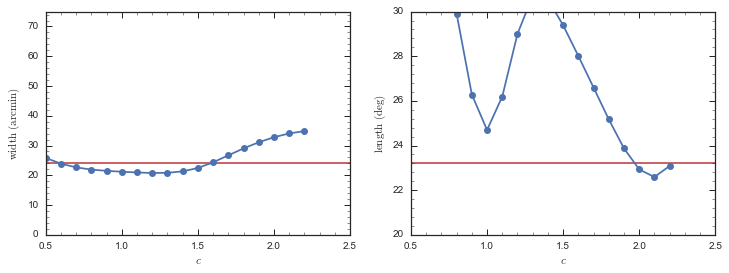

In [45]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another one to test:

In [46]:
p_b15= [0.45,0.45,-1.,-3.2,0.9,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-somescale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

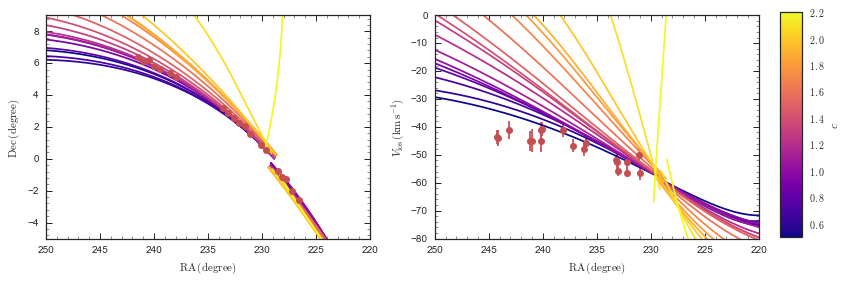

In [47]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

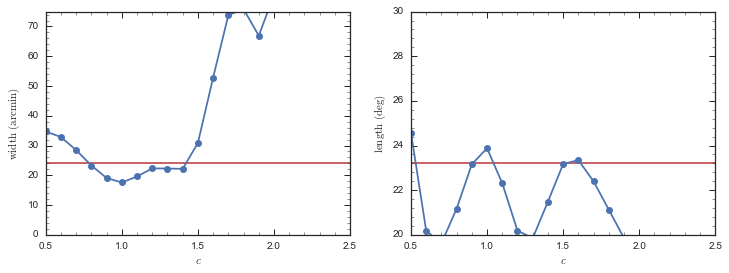

In [48]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## Different distances

In [49]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-D22p5.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.])
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,dist=22.5,interpk=1,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.6,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

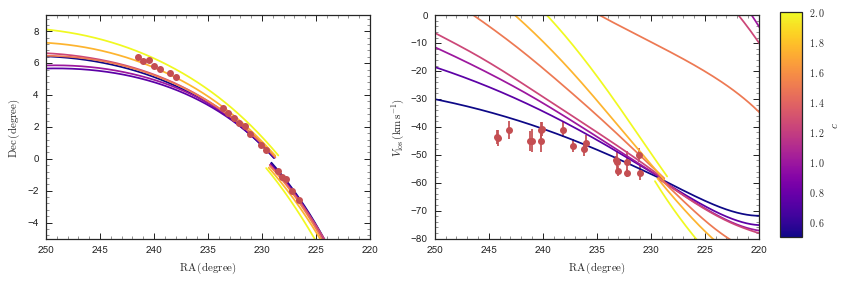

In [50]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < 1.2 or c > 1.3: continue
#    if c < 2.: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

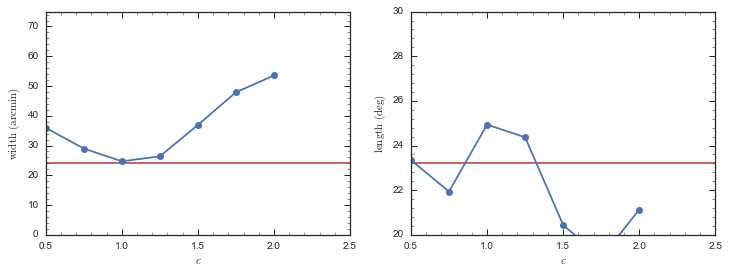

In [51]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

In [52]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-D24p5.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.8,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,dist=24.5,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

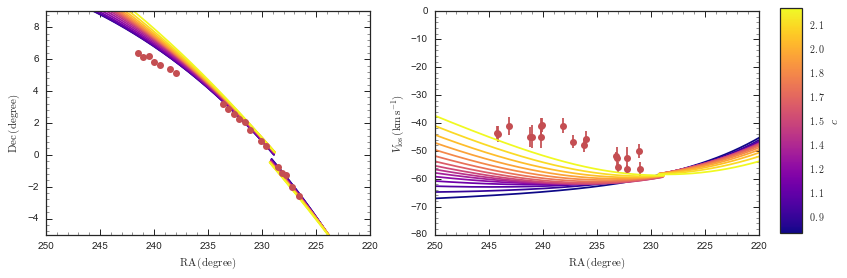

In [53]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c > 1.: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

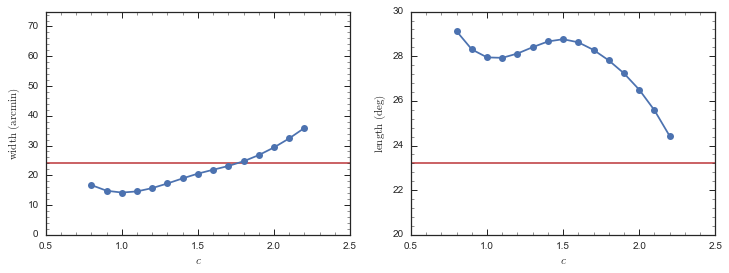

In [54]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## A very dens grid of models

In [55]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-like.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_like= pickle.load(savefile)
else:
    # First just compute the interpolation points, to adjust the width and length
    interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25]
    pal5varyc= pal5_util.predict_pal5obs(p_b15,interpcs,multi=8,interpcs=interpcs)
    cs= numpy.arange(0.5,2.21,0.01)
    sigv=0.4*18./pal5varyc[4]
    td=5.*25./pal5varyc[5]/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_like= pal5_util.predict_pal5obs(p_b15,cs,multi=8,interpcs=pal5varyc[6],
                                              sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_like)

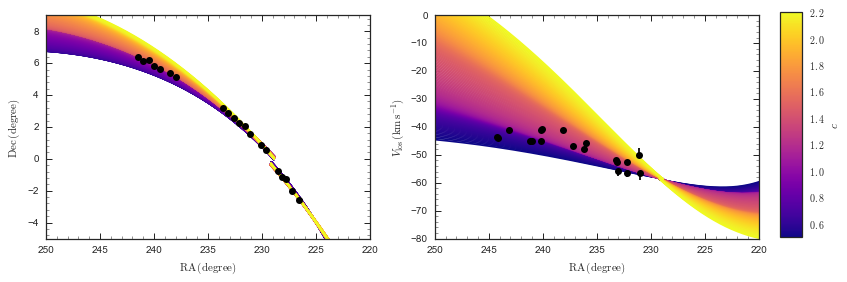

In [56]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_like[0][ii,:,0],
                        pal5varyc_like[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[1][ii,:,0],
                        pal5varyc_like[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_like[2][ii,:,0],
                        pal5varyc_like[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[3][ii,:,0],
                        pal5varyc_like[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

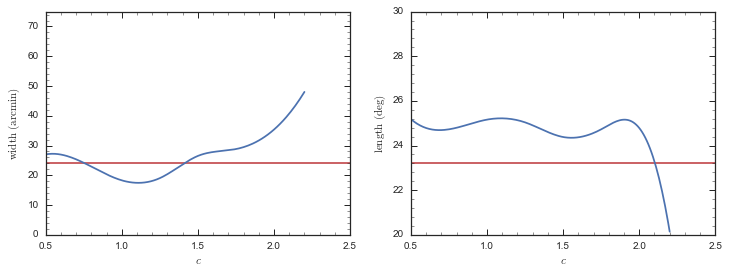

In [57]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_like[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_like[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

# MCMC results

In [76]:
# Read the necessary data for MWPotential2014Likelihood
reload(MWPotential2014Likelihood)
#First read the surface densities
surffile= '../mwpot14data/bovyrix13kzdata.csv'
if not surffile is None and os.path.exists(surffile):
    surf= numpy.loadtxt(surffile,delimiter=',')
    surfrs= surf[:,2]
    kzs= surf[:,6]
    kzerrs= surf[:,7]*1000.
# Then the terminal velocities
cl_glon, cl_vterm, cl_corr= MWPotential2014Likelihood.readClemens(dsinl=0.125)
mc_glon, mc_vterm, mc_corr= MWPotential2014Likelihood.readMcClureGriffiths(dsinl=0.125)
termdata= (cl_glon,cl_vterm,cl_corr,
           mc_glon,mc_vterm,mc_corr)
def evi_harmonic(x):
    # Simple harmonic mean estimator of the evidence, bad!!
    return 1./numpy.mean(numpy.exp(-x[:,-1]))
def evi_laplace(x):
    # Laplace estimator of the evidence
    mindx= numpy.argmax(x[:,-1])
    C= numpy.cov(x[:,:6],rowvar=False)
    return numpy.exp(x[mindx,-1])/numpy.sqrt(numpy.linalg.det(C))
def determine_nburn(filename='../pal5_mcmc/mwpot14-fitsigma-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[\
                   (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.)][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[\
                   (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.)][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100
def read_mcmc(filename='../pal5_mcmc/mwpot14-fitsigma-*.dat',nburn=None,
             evi_func=evi_laplace,evi_cut=-10.,
             addforces=False,addmwpot14weights=False,
             singlepot=None,skip=1):
    fn= glob.glob(filename)
    alldata= numpy.zeros((0,7+2*addforces))
    indx= numpy.zeros((0,1))
    weights= numpy.zeros((0,1))
    evis= numpy.zeros((0,1))
    for f in tqdm.tqdm(fn):
        pindx= int(f.split('-')[2].split('.dat')[0])
        if pindx == 14 or pindx > 27: 
            print("Remember: skipping 14 and > 27 for now ...")
            continue
        if not singlepot is None and not pindx == singlepot: continue
        try:
            if nburn is None:
                tnburn= determine_nburn(f)
            else:
                 tnburn= nburn   
            tdata= numpy.loadtxt(f,comments='#',delimiter=',')
            tdata= tdata[tnburn::skip]
            tdata= tdata[tdata[:,-1] > numpy.nanmax(tdata[:,-1])+evi_cut]
            if len(tdata) < 100: continue
        except: continue # not enough samples yet
        #Needs to be before addforces, because evi uses -1 as the lnlike index
        tweights= numpy.ones((len(tdata),1))/float(len(tdata))*evi_func(tdata)
        evis= numpy.vstack((evis,numpy.ones((len(tdata),1))*evi_func(tdata)))
        if addforces:
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            forces= numpy.empty((len(tdata),2))
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,
                                                               pal5_util._REFR0,tvo)
                forces[ee,:]= MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo)[:2]
            tdata= numpy.hstack((tdata,forces))
        if addmwpot14weights:
            # Not terribly useful right now
            # Add the relative importance weights of this (c,vc) compared to the one 
            # that this potential was sampled from
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            # Also load the samples to find the c that this set was sampled with
            with open('mwpot14varyc-samples.pkl','rb') as savefile:
                s= pickle.load(savefile)
            rndindx= numpy.argmin(numpy.fabs(s[0]-potparams[0]))
            pot_params= s[:,rndindx]
            print pot_params[7]
            base_like= MWPotential2014Likelihood.like_func(\
                                    pot_params,pot_params[7],
                                    surfrs,kzs,kzerrs,termdata,700.,False,False,False,
                                    False,pal5_util._REFR0,220.)
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                tweights[ee]*= numpy.exp(-MWPotential2014Likelihood.like_func(\
                                    pot_params,c,surfrs,kzs,kzerrs,termdata,700.,False,False,False,
                                    False,pal5_util._REFR0,tvo) # last one is no vo prior
                                         +base_like)
        # Only keep 
        alldata= numpy.vstack((alldata,tdata))
        indx= numpy.vstack((indx,numpy.zeros((len(tdata),1),dtype='int')+pindx))
        weights= numpy.vstack((weights,tweights))
    return (alldata,indx[:,0],weights[:,0],evis[:,0]) 
def plot_corner(alldata,weights=None,addvcprior=False,addforces=False):
    alldata= copy.deepcopy(alldata)
    weights= copy.deepcopy(weights)
    # First adjust for factors
    alldata[:,1]*= pal5_util._REFV0
    if addvcprior:
        weights*= numpy.exp(-0.5*(alldata[:,1]-220.)**2./100.)
    alldata[:,2]*= 22.
    alldata[:,5]= 0.4*numpy.exp(alldata[:,5])
    trange= [(0.5,1.5),(200.,250.),(19.,24.),
             (-0.4,0.4),(-.1,0.1),(0.1,1.)]                 
    labels= [r'$c$',r'$V_c(R_0)$',r'$D_{\mathrm{Pal\ 5}}$',
             r'$\mu_\parallel$',r'$\mu_\perp$',r'$\sigma_v$']
    if addforces or alldata.shape[1] == 9: # forces, don't plot likelihood
        alldata= alldata[:,[0,1,2,3,4,5,7,8]]
        trange.extend([(-1.15,-0.6),(-2.5,-1.25)])
        labels.extend([r'$F_{R,\mathrm{Pal\ 5}}$',r'$F_{Z,\mathrm{Pal\ 5}}$'])
    else: # no forces, plot likelihood as well
        alldata= alldata[:,:7]
        trange.append((-30.,-18.))
        labels.append(r'$\ln \mathcal{L}$')
    corner.corner(alldata,quantiles=[0.16,0.5,0.84],range=trange,weights=weights,
                  labels=labels,show_titles=True,title_args={"fontsize": 12})

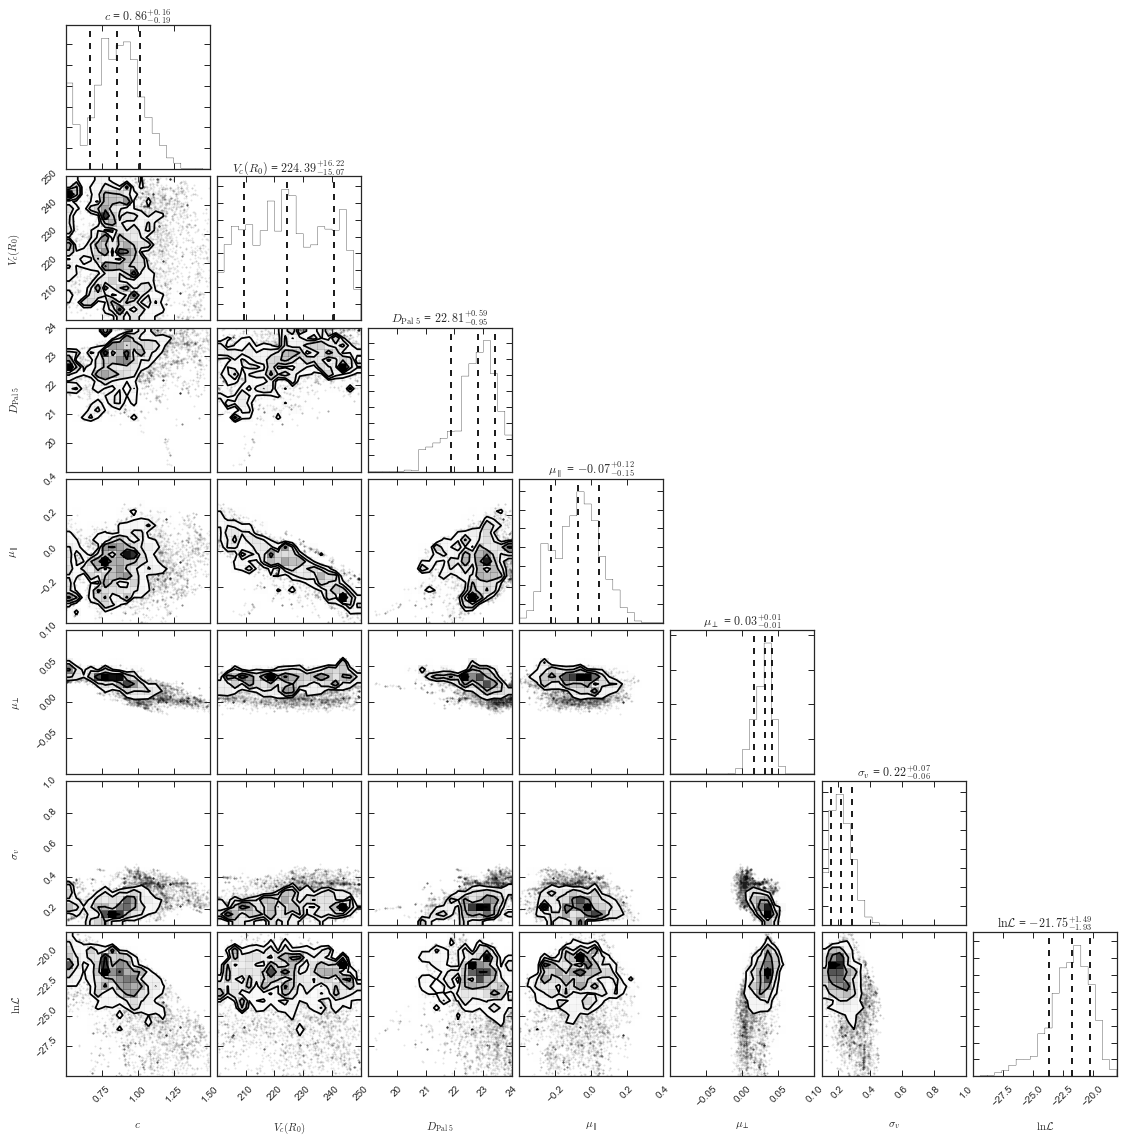

In [74]:
data,_,weights,_= read_mcmc(nburn=None,evi_func=evi_harmonic,skip=10)
plot_corner(data,weights=weights)

In [140]:
data_wf,index_wf,weights_wf,evi_wf= read_mcmc(nburn=None,addforces=True,skip=10,
                                  evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))

 62%|██████▎   | 20/32 [01:59<01:09,  5.76s/it]

Remember: skipping 14 and > 27 for now ...
Remember: skipping 14 and > 27 for now ...

 75%|███████▌  | 24/32 [02:05<00:36,  4.50s/it]


Remember: skipping 14 and > 27 for now ...
Remember: skipping 14 and > 27 for now ...


Remember: skipping 14 and > 27 for now ...


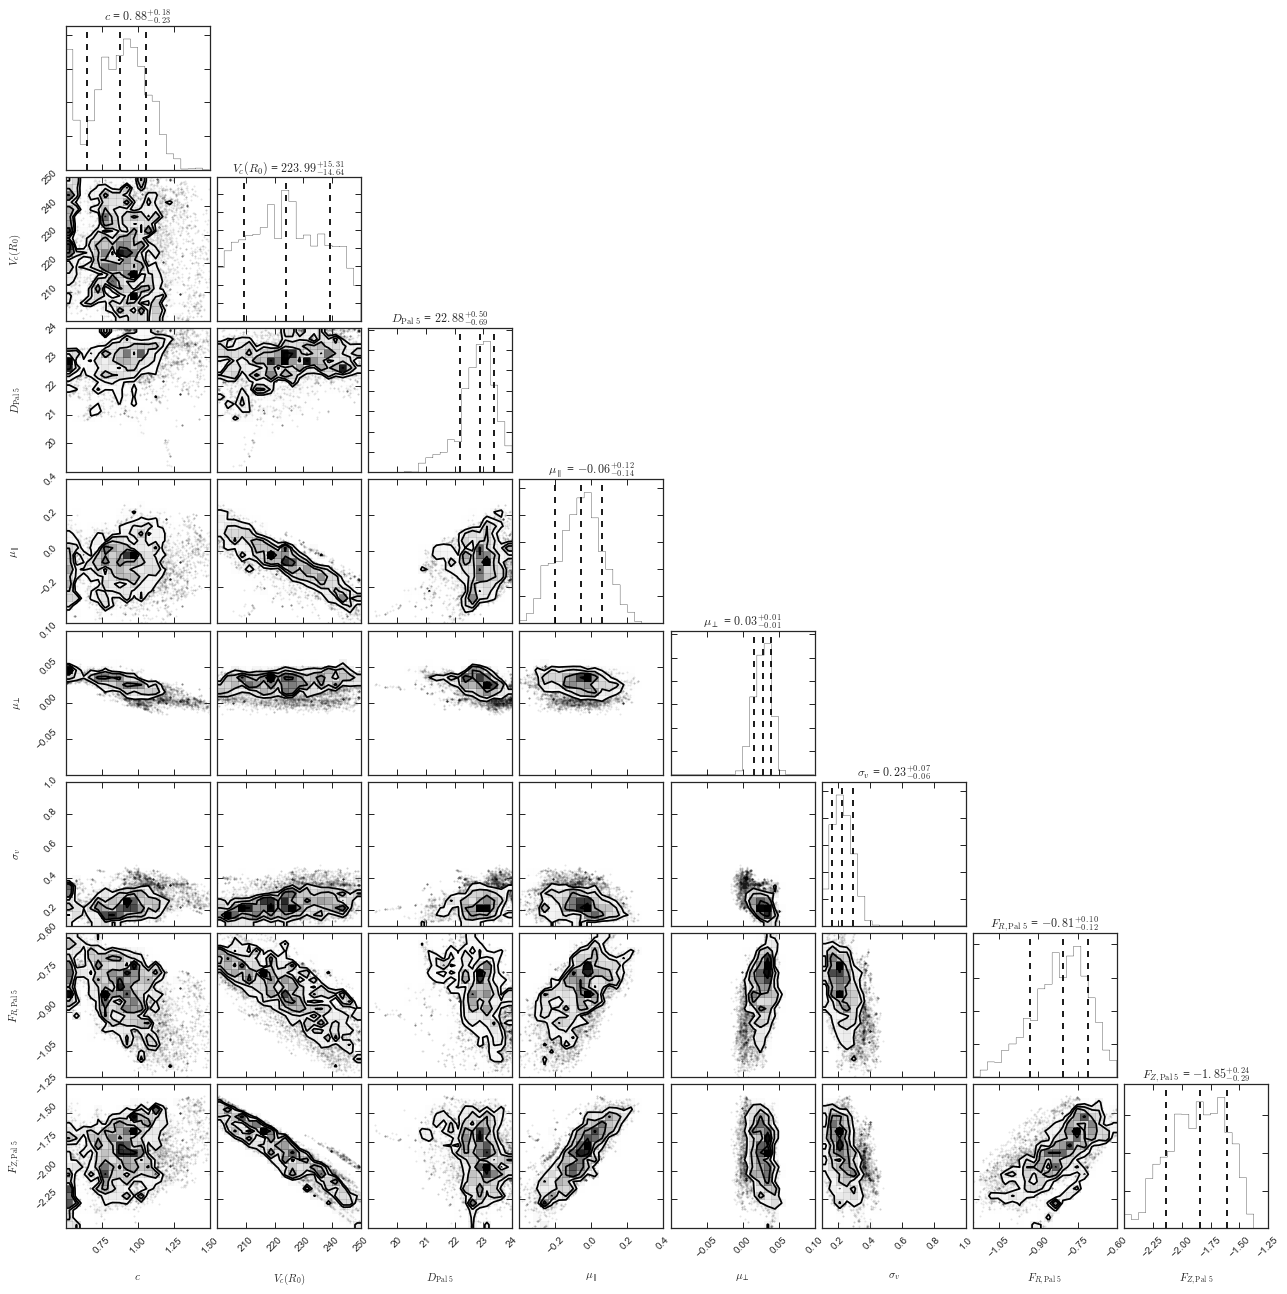

In [68]:
plot_corner(data_wf,weights=weights_wf,addvcprior=False)

The posterior PDF for the potential flattening:

0.937231960334 0.0476504941289


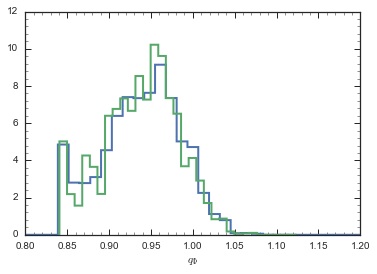

In [185]:
figsize(6,4)
bins= 31
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.8,1.2],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),
                         weights=weights_wf*numpy.exp(-0.5*(data_wf[:,1]-1.)**2./(10./220.)**2.),
                         bins=bins,histtype='step',lw=2.,normed=True,overplot=True)
mq= numpy.sum(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])*weights_wf)/numpy.sum(weights_wf)
print mq, numpy.sqrt(numpy.sum((numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])-mq)**2.*weights_wf)/numpy.sum(weights_wf))

Which potential is preferred?

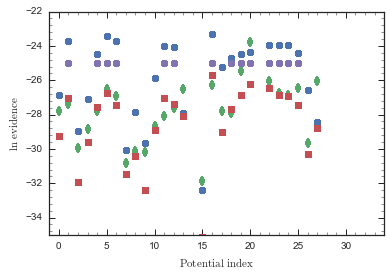

In [73]:
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_harmonic)
figsize(6,4)
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    xrange=[-1,34],
                    yrange=[-35,-22],
                   xlabel=r'$\mathrm{Potential\ index}$',
                   ylabel=r'$\ln\ \mathrm{evidence}$')
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_laplace)
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-30.,'d',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(numpy.amax(x[:,-1])))
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-8.,'s',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    overplot=True)

## The convergence of different walkers for each potential:

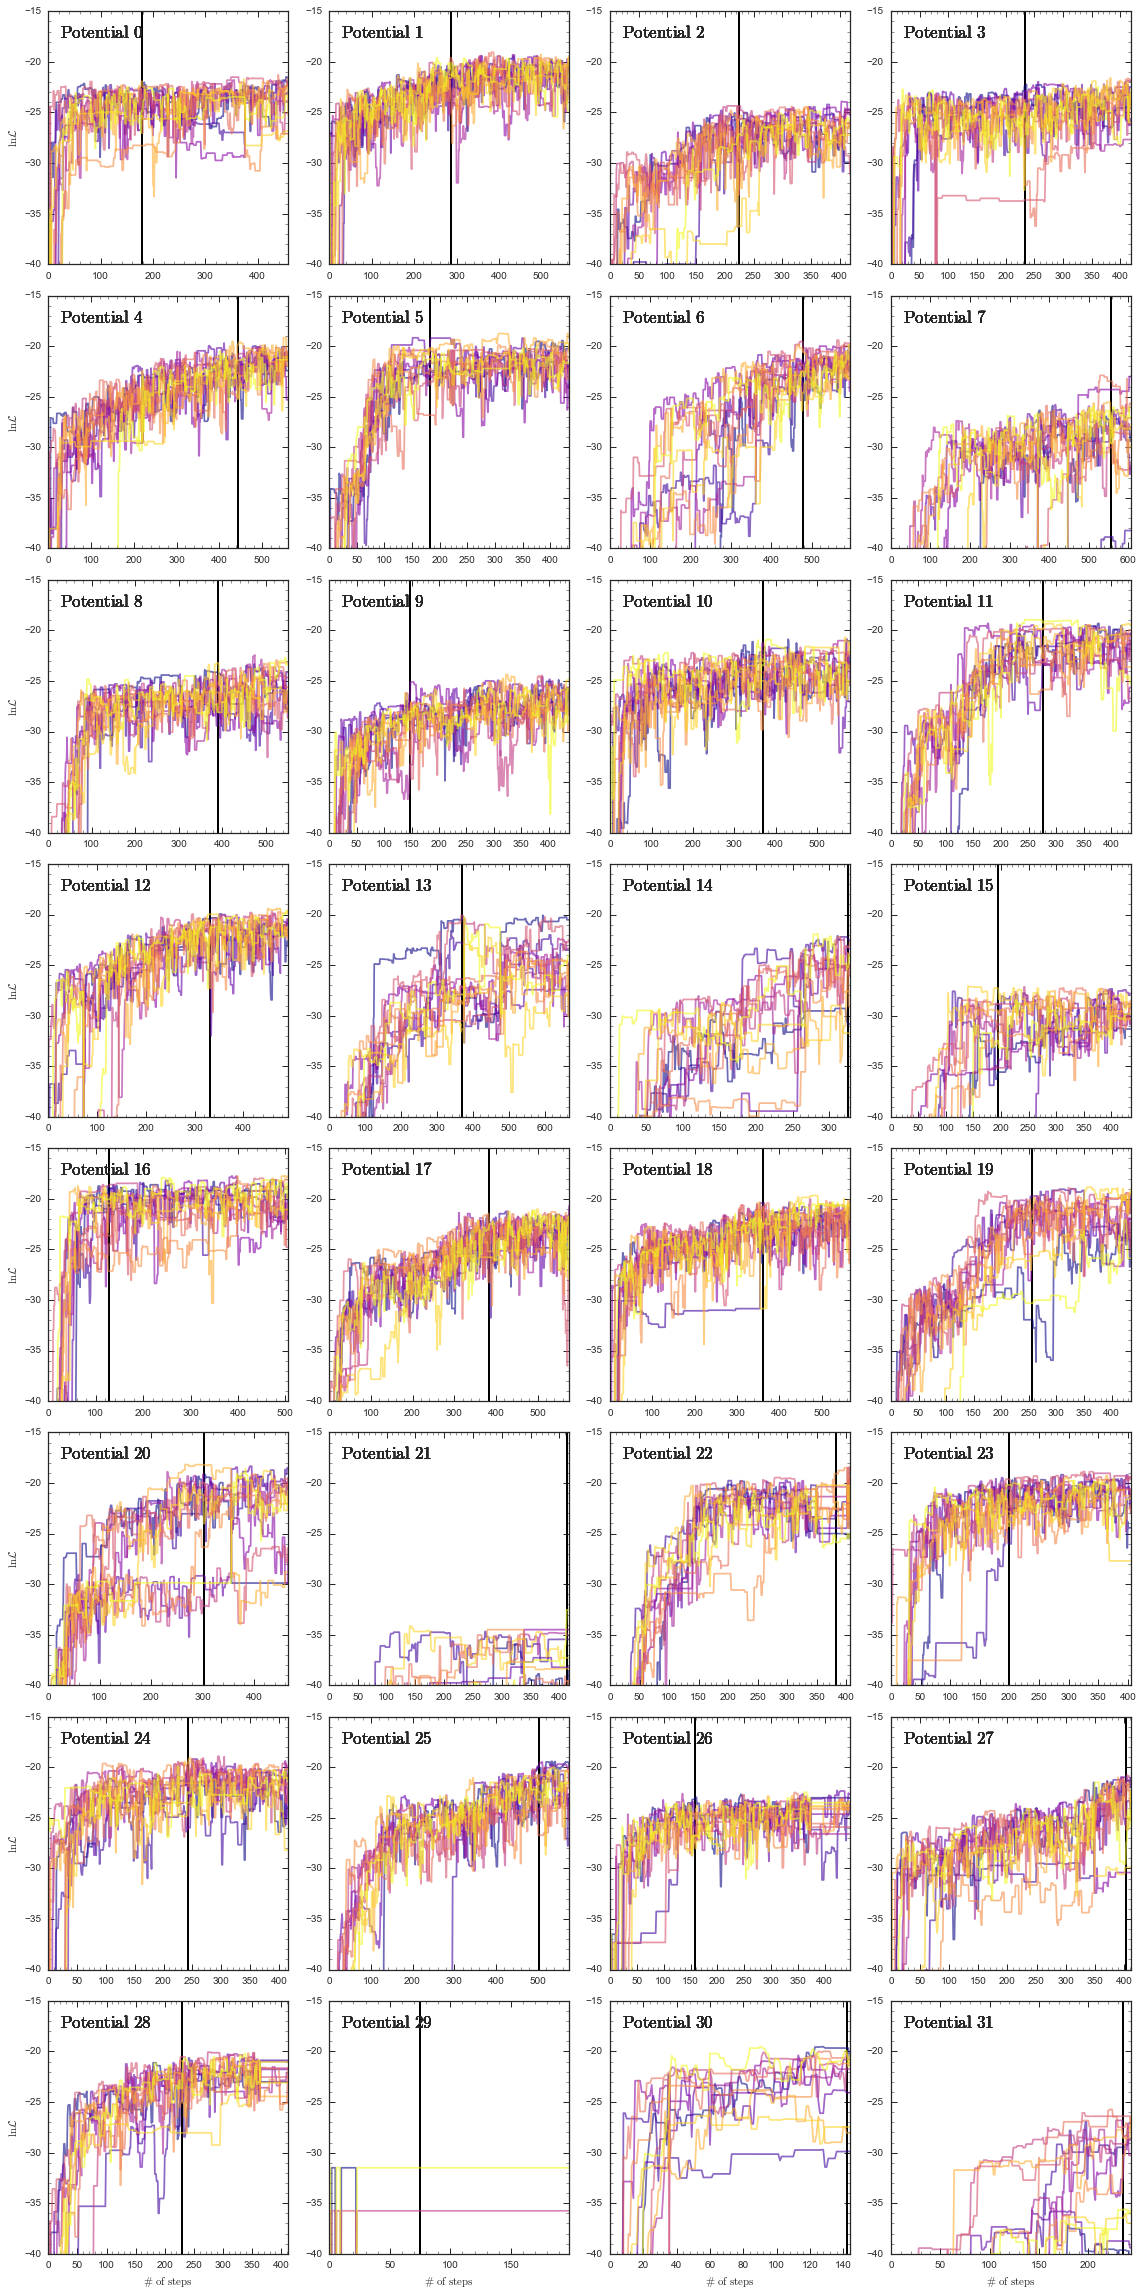

In [188]:
npot= 32
nwalkers= 12
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
cmap= cm.plasma
from __builtin__ import range
for en,ii in enumerate(range(npot)):
    fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
    data= numpy.loadtxt(fn,comments='#',delimiter=',')
    subplot(nrow,4,en+1)
    sdata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    for jj in range(nwalkers):
        if ii%4 == 0 and jj == 0:
            ylabel=r'$\ln \mathcal{L}$'
        else:
            ylabel= None
        if ii//4 == nrow-1 and jj == 0:
            xlabel= r'$\#\ \mathrm{of\ steps}$'
        else:
            xlabel= None
        bovy_plot.bovy_plot(range(len(sdata[:,jj])),sdata[:,jj],
                            '-',alpha=0.6,
                            color=cmap(jj/11.),
                            yrange=[-40.,-15.],
                            ylabel=ylabel,xlabel=xlabel,
                            gcf=True)
        bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                            top_left=True)
    nburn= determine_nburn(fn)//nwalkers
    pyplot.axvline(nburn,lw=2.,zorder=1,color='k')
tight_layout()

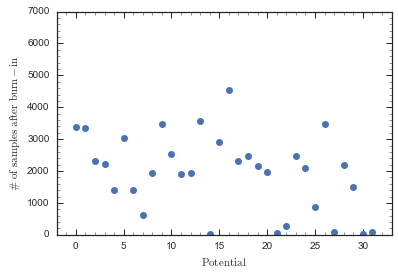

In [193]:
figsize(6,4)
nsamps= numpy.zeros(npot)
for en,ii in enumerate(range(npot)):
    fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
    nsamps[en]= determine_nburn(fn,return_nsamples=True)
bovy_plot.bovy_plot(numpy.arange(npot),nsamps,
                   'o',
                    xrange=[-2.,33.],
                    yrange=[0.,7000.],
                    xlabel=r'$\mathrm{Potential}$',
                    ylabel=r'$\#\ \mathrm{of\ samples\ after\ burn-in}$')

## Look at the results for individual potentials

### The flattening $c$

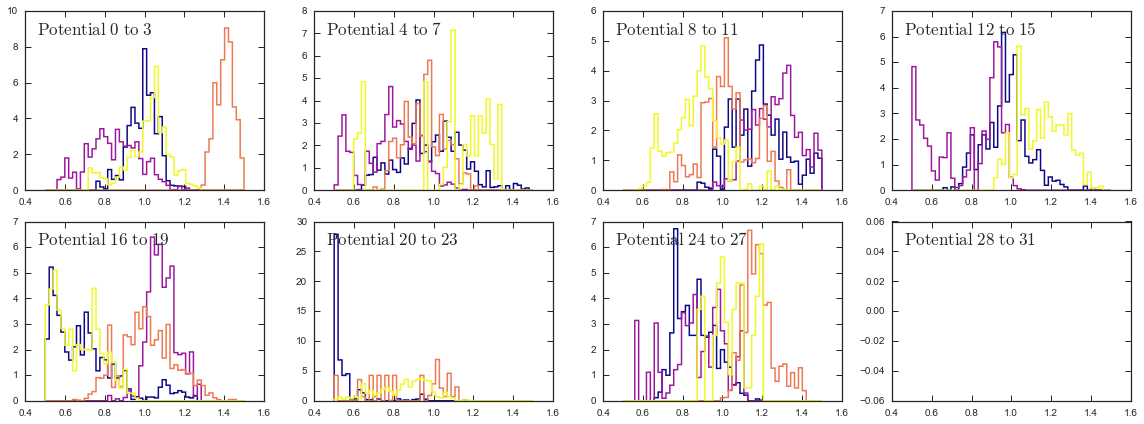

In [58]:
npot= 32
nwalkers= 12
figsize(16,6)
cmap= cm.plasma
maxl= numpy.zeros((npot,2))
for en,ii in enumerate(range(npot)):
    data_ip,_,weights_ip,evi_ip= read_mcmc(singlepot=ii,evi_func=evi_harmonic)
    try:
        maxl[en,0]= numpy.amax(data_ip[:,-1])
        maxl[en,1]= numpy.log(evi_ip[0])
    except ValueError:
        maxl[en]= -10000000.
    subplot(2,4,en//4+1)
    bovy_plot.bovy_hist(data_ip[:,0],range=[0.5,1.5],bins=51,
                        histtype='step',color=cmap((en%4)/3.),
                        normed=True,xlabel=r'$c$',lw=1.5,
                        overplot=True)
    if en%4 == 0:
        bovy_plot.bovy_text(r'$\mathrm{Potential\ %i\ to\ % i}$' % (en,en+3),size=17.,
                            top_left=True)
tight_layout()

### The force $F_R$

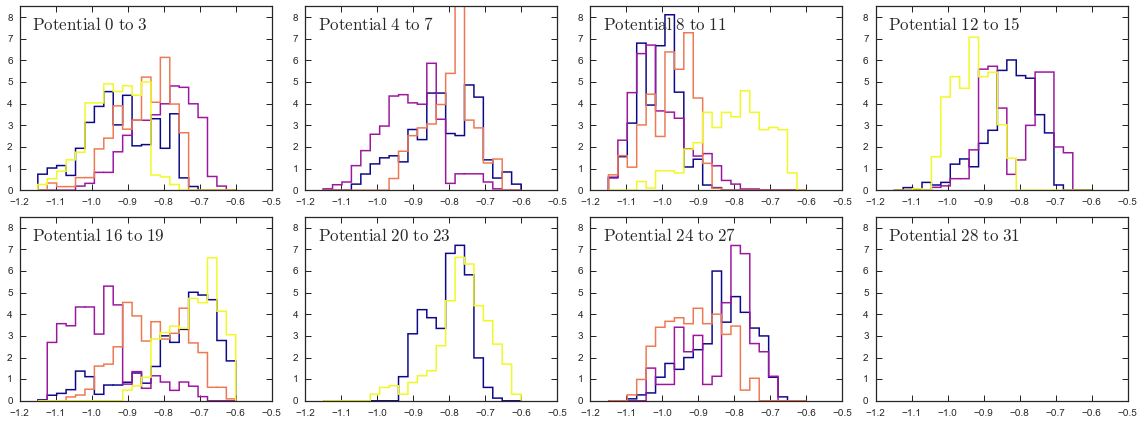

In [36]:
npot= 32
nwalkers= 12
figsize(16,6)
cmap= cm.plasma
bestfs= numpy.empty((npot,3))
for en,ii in enumerate(range(npot)):
    data_ip,_,weights_ip,_= read_mcmc(singlepot=ii,addforces=True,skip=5)
    try:
        bestfs[en,:2]= data_ip[numpy.argmax(data_ip[:,6]),7:]
        bestfs[en,2]= data_ip[numpy.argmax(data_ip[:,6]),0]
    except ValueError:
        bestfs[en]= -1000.
    subplot(2,4,en//4+1)
    bovy_plot.bovy_hist(data_ip[:,7],bins=21,range=[-1.15,-0.6],
                        histtype='step',color=cmap((en%4)/3.),
                        normed=True,xlabel=r'$F_R$',lw=1.5,
                        overplot=True)
    ylim(0.,8.5)
    if en%4 == 0:
        bovy_plot.bovy_text(r'$\mathrm{Potential\ %i\ to\ % i}$' % (en,en+3),size=17.,
                            top_left=True)
tight_layout()

### The force $F_Z$

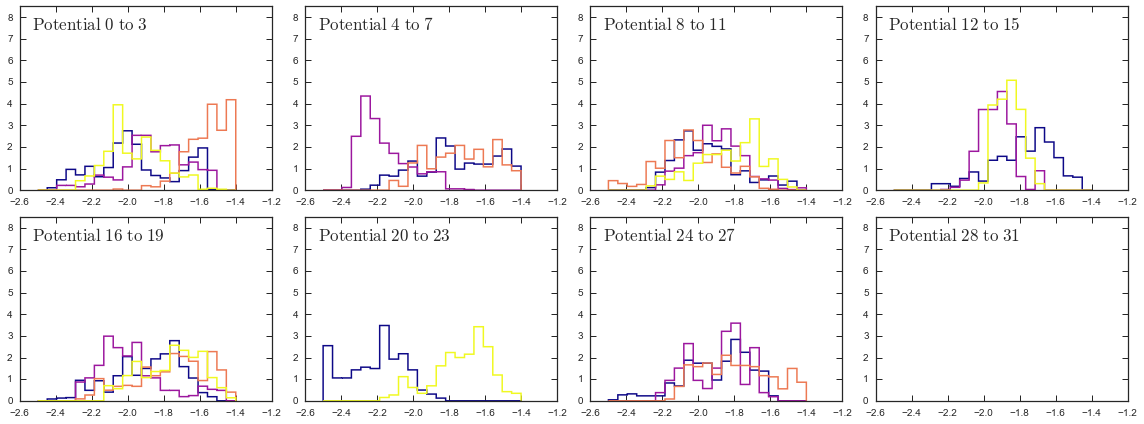

In [37]:
npot= 32
nwalkers= 12
figsize(16,6)
cmap= cm.plasma
for en,ii in enumerate(range(npot)):
    data_ip,_,weights_ip,_= read_mcmc(singlepot=ii,addforces=True,skip=5)
    subplot(2,4,en//4+1)
    bovy_plot.bovy_hist(data_ip[:,8],bins=21,range=[-2.5,-1.4],
                        histtype='step',color=cmap((en%4)/3.),
                        normed=True,xlabel=r'$F_Z$',lw=1.5,
                        overplot=True)
    ylim(0.,8.5)
    if en%4 == 0:
        bovy_plot.bovy_text(r'$\mathrm{Potential\ %i\ to\ % i}$' % (en,en+3),size=17.,
                            top_left=True)
tight_layout()

### Best-fit forces for all

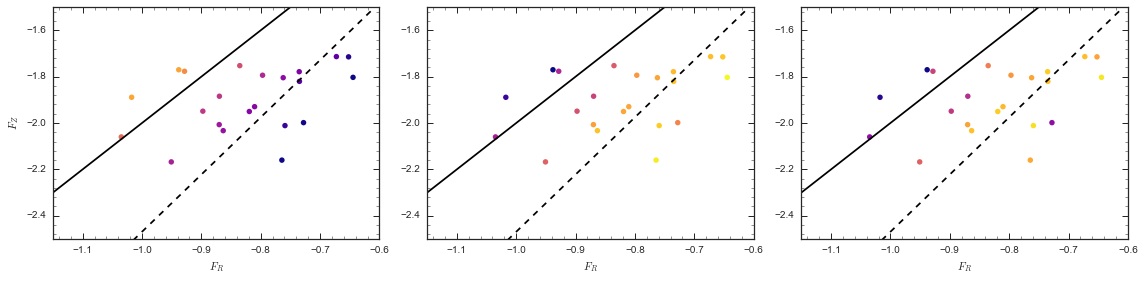

In [62]:
def qline(fr,q=0.975):
    return 2.*fr/q**2.
q= 0.9
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(bestfs[:,0],bestfs[:,1],
                    c=bestfs[:,2],s=30.,
                    vmin=0.5,vmax=1.5,
                    edgecolors='none',scatter=True,
                    cmap=cm.plasma,
                    xrange=[-1.15,-0.6],
                    yrange=[-2.5,-1.5],
                    xlabel=r'$F_R$',ylabel=r'$F_Z$',
                    gcf=True)
plot([-1.25,-0.75],[-2.5,-1.5],'k-')
plot([-1.25,-0.6],[qline(-1.25,q=q),qline(-0.6,q=q)],'k--')
subplot(1,3,2)
bovy_plot.bovy_plot(bestfs[:,0],bestfs[:,1],
                    c=maxl[:,0],s=30.,
                    vmin=-25.,vmax=-18.,
                    edgecolors='none',scatter=True,
                    cmap=cm.plasma,
                    xrange=[-1.15,-0.6],
                    yrange=[-2.5,-1.5],
                    xlabel=r'$F_R$',
                    gcf=True)
plot([-1.25,-0.75],[-2.5,-1.5],'k-')
plot([-1.25,-0.6],[qline(-1.25,q=q),qline(-0.6,q=q)],'k--')
subplot(1,3,3)
bovy_plot.bovy_plot(bestfs[:,0],bestfs[:,1],
                    c=maxl[:,1],s=30.,
                    vmin=-30.,vmax=-23.,
                    edgecolors='none',scatter=True,
                    cmap=cm.plasma,
                    xrange=[-1.15,-0.6],
                    yrange=[-2.5,-1.5],
                    xlabel=r'$F_R$',
                    gcf=True)
plot([-1.25,-0.75],[-2.5,-1.5],'k-')
plot([-1.25,-0.6],[qline(-1.25,q=q),qline(-0.6,q=q)],'k--')
tight_layout()

## What is the effective prior in $(F_R,F_Z)$?

In [92]:
frfzprior_savefilename= 'frfzprior.pkl'
if not os.path.exists(frfzprior_savefilename):
    # Compute for each potential separately
    nvoc= 1000
    ro= 8.
    npot= 32
    fs= numpy.zeros((2,nvoc,npot))
    for en,ii in tqdm.tqdm(enumerate(range(npot))):
        fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
        # Read the potential parameters
        with open(fn,'rb') as savefile:
            line1= savefile.readline()
        potparams= [float(s) for s in (line1.split(':')[1].split(','))]
        for jj in range(nvoc):
            c= numpy.random.uniform()*1.5+0.5
            tvo= numpy.random.uniform()*50.+200.
            pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
            fs[:,jj,ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))[:2]
    save_pickles(frfzprior_savefilename,fs)
else:
    with open(frfzprior_savefilename,'rb') as savefile:
        fs= pickle.load(savefile)

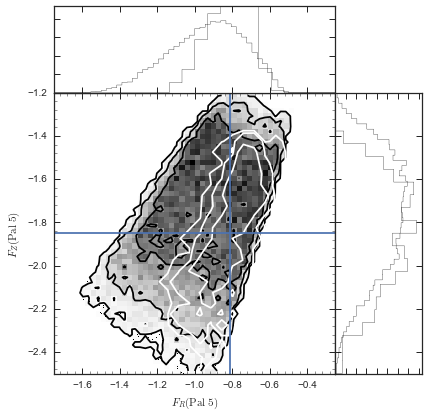

In [112]:
figsize(6,6)
bovy_plot.scatterplot(fs[0].flatten(),
                      fs[1].flatten(),
                      'k,',
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      ylabel=r'$F_Z(\mathrm{Pal\ 5})$',
                     onedhists=True)
bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                      weights=weights_wf,bins=26,
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True,
                      onedhists=True)
pyplot.axvline(-0.81,color=sns.color_palette()[0])
pyplot.axhline(-1.85,color=sns.color_palette()[0])

The ratio of the posterior and the prior:

0.941534113289


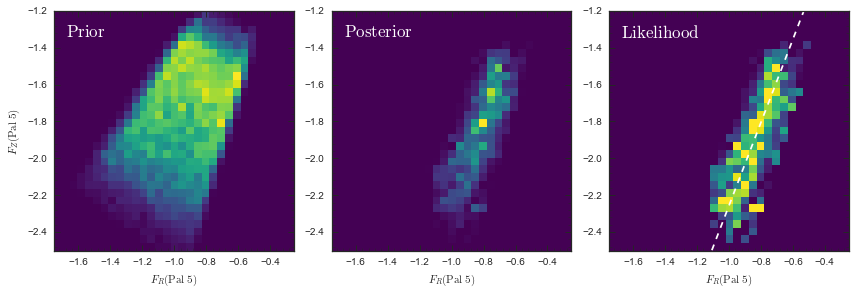

In [145]:
figsize(12,4)
bins= 31
trange= [[-1.75,-0.25],[-2.5,-1.2]]
tw= copy.deepcopy(weights_wf)
tw[index_wf == 20]= 0.
H_prior, xedges, yedges= numpy.histogram2d(fs[0].flatten(),fs[1].flatten(),bins=bins,range=trange,normed=True)
H_post, xedges, yedges= numpy.histogram2d(data_wf[:,7],data_wf[:,8],weights=tw,
                                          bins=bins,range=trange,normed=True)
H_like= (H_post/H_prior)
H_like[H_prior == 0.]= 0.
subplot(1,3,1)
bovy_plot.bovy_dens2d(H_prior.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      ylabel=r'$F_Z(\mathrm{Pal\ 5})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathrm{Prior}$',top_left=True,size=17.,color='w')
subplot(1,3,2)
bovy_plot.bovy_dens2d(H_post.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathrm{Posterior}$',top_left=True,size=17.,color='w')
subplot(1,3,3)
bovy_plot.bovy_dens2d(H_like.T,origin='lower',cmap='viridis',
                      interpolation='nearest',vmin=0.1,vmax=4.,
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathrm{Likelihood}$',top_left=True,size=17.,color='w')
q= numpy.sqrt(2.*0.82/1.85)
plot([-1.25,-0.2],[qline(-1.25,q=q),qline(-0.2,q=q)],'w--')
print q
tight_layout()

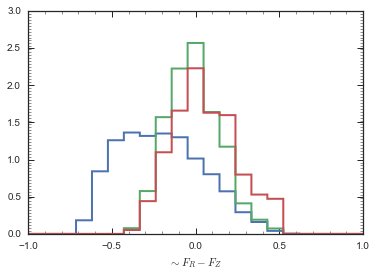

In [182]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(bins,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(bins,1))
figsize(6,4)
minus= -1.
if minus == 1.:
    xlabel= r'$\sim F_R+F_Z$'
else:
    xlabel= r'$\sim F_R-F_Z$'
dum= bovy_plot.bovy_hist(((frs+0.82)+minus*(fzs+1.85)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.,1.],xlabel=xlabel,normed=True)
dum= bovy_plot.bovy_hist(((frs+0.82)+minus*(fzs+1.85)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
dum= bovy_plot.bovy_hist(((frs+0.82)+minus*(fzs+1.85)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)

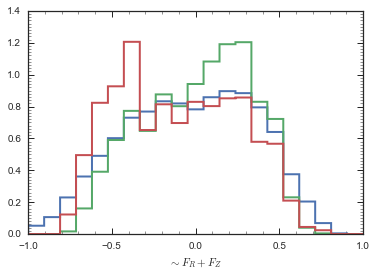

In [183]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(bins,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(bins,1))
figsize(6,4)
minus= 1.
if minus == 1.:
    xlabel= r'$\sim F_R+F_Z$'
else:
    xlabel= r'$\sim F_R-F_Z$'
dum= bovy_plot.bovy_hist(((frs+0.82)+minus*(fzs+1.85)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.,1.],xlabel=xlabel,normed=True)
dum= bovy_plot.bovy_hist(((frs+0.82)+minus*(fzs+1.85)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
dum= bovy_plot.bovy_hist(((frs+0.82)+minus*(fzs+1.85)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)

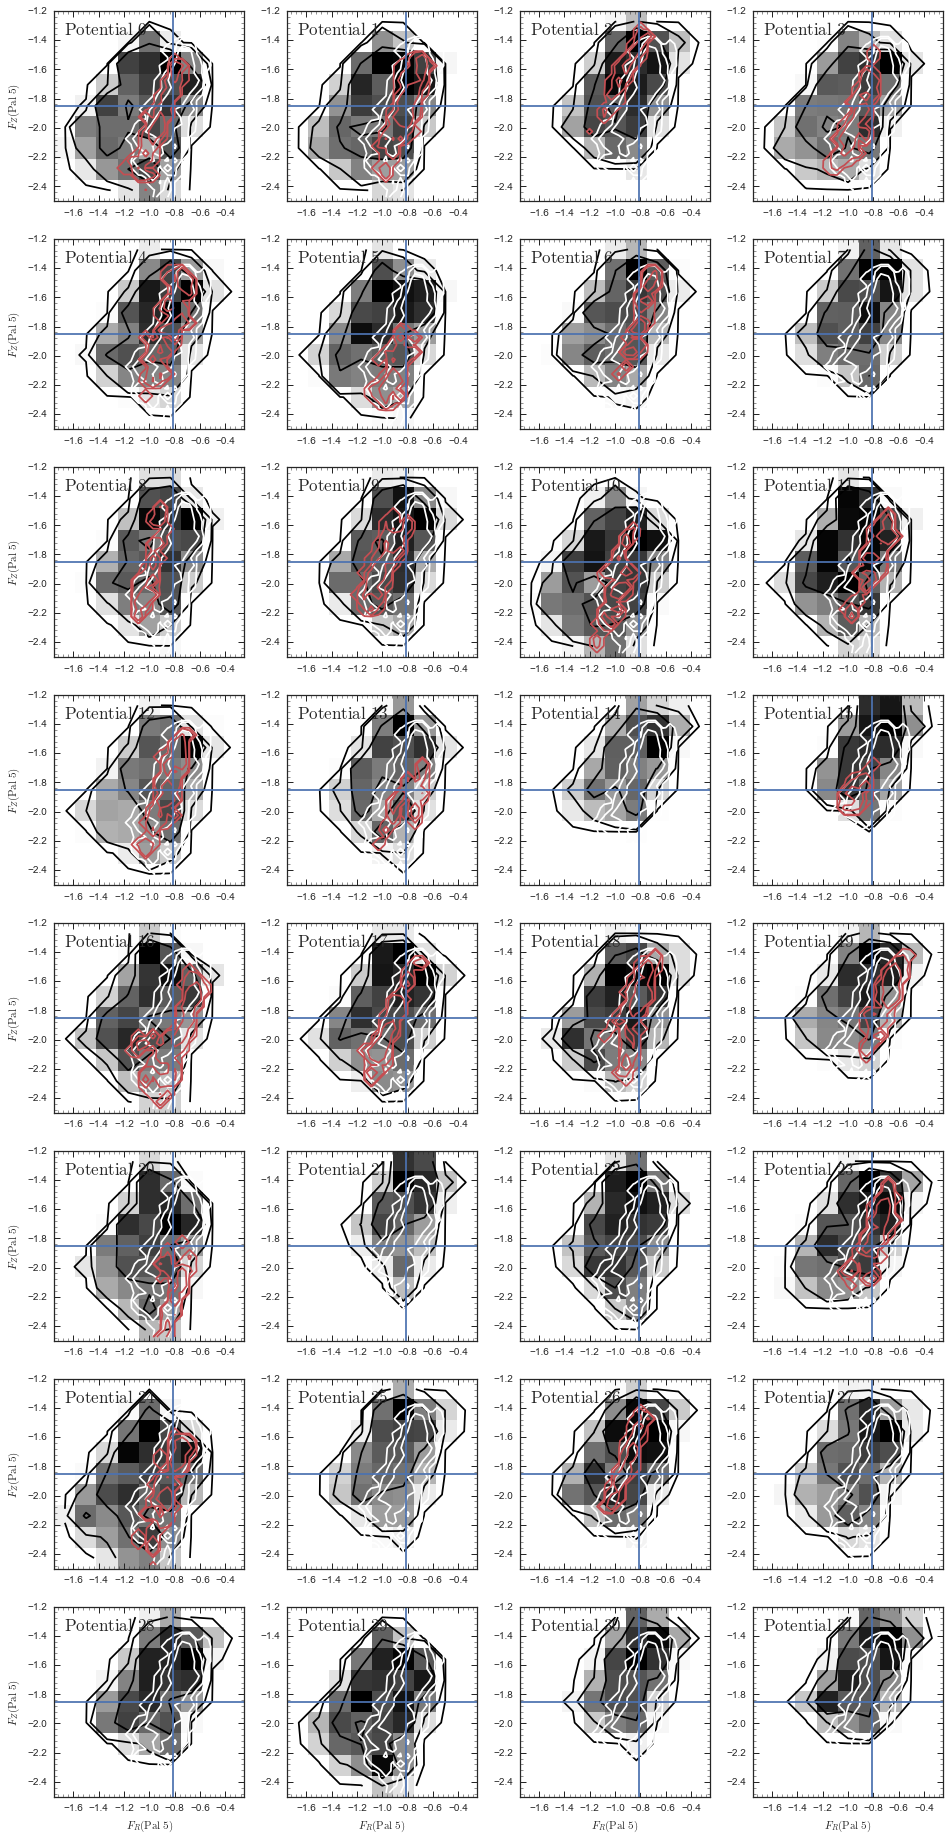

In [192]:
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
for en,ii in enumerate(range(npot)):
    subplot(nrow,4,en+1)
    if ii%4 == 0:
        ylabel=r'$F_Z(\mathrm{Pal\ 5})$'
    else:
        ylabel= None
    if ii//4 == nrow-1:
        xlabel= r'$F_R(\mathrm{Pal\ 5})$'
    else:
        xlabel= None
    bovy_plot.scatterplot(fs[0][:,en],fs[1][:,en],
                          'k,',
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.2],
                          xlabel=xlabel,
                          ylabel=ylabel,
                          gcf=True)
    bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                      weights=weights_wf,bins=26,
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True)
    bovy_plot.scatterplot(data_wf[index_wf == ii,7],
                          data_wf[index_wf == ii,8],
                          weights=weights_wf[index_wf == ii],
                          bins=26,
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.2],
                          justcontours=True,
                          cntrcolors=sns.color_palette()[2],
                          overplot=True)
    pyplot.axvline(-0.81,color=sns.color_palette()[0])
    pyplot.axhline(-1.85,color=sns.color_palette()[0])
    bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                        top_left=True)

### What about $q_\Phi$?

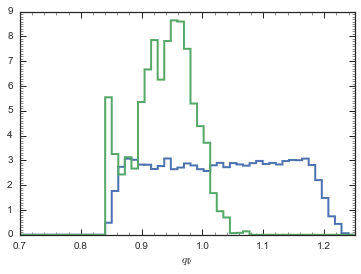

In [138]:
bins= 51
figsize(6,4)
dum= bovy_plot.bovy_hist(numpy.sqrt(2.*fs[0].flatten()/fs[1].flatten()),
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.7,1.25],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         overplot=True,xrange=[0.7,1.25],normed=True)

From the likelihood (=posterior/prior) alone:

0.935742412434 0.0492499105334


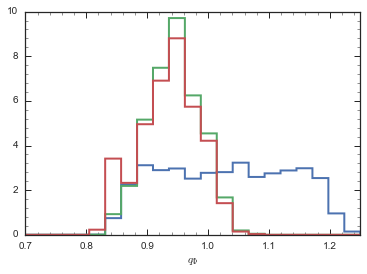

In [184]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(bins,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(bins,1))
figsize(6,4)
dum= bovy_plot.bovy_hist(numpy.sqrt(2.*frs/fzs).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[0.7,1.25],normed=True,
                         yrange=[0.,10.],
                        xlabel=r'$q_\Phi$')
dum= bovy_plot.bovy_hist(numpy.sqrt(2.*frs/fzs).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[0.7,1.25],normed=True,overplot=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(2.*frs/fzs).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[0.7,1.25],normed=True,overplot=True)
mq= (numpy.sum(numpy.sqrt(2.*frs/fzs).flatten()*H_like.flatten()))/numpy.sum(H_like.flatten())
print mq, numpy.sqrt((numpy.sum((numpy.sqrt(2.*frs/fzs).flatten()-mq)**2.*H_like.flatten()))/numpy.sum(H_like.flatten()))

Is the Kuepper et al. potential a good fit?

In [31]:
from galpy import potential
import astropy.units as u
bestd= 23.12
bestpmoff= -0.2
vo,ro= 238.2, 8.29
pot= [potential.HernquistPotential(amp=3.4*10.**10.*u.Msun,a=0.7*u.kpc,ro=ro,vo=vo),
      potential.MiyamotoNagaiPotential(amp=10.**11.*u.Msun,a=6.5*u.kpc,b=0.26*u.kpc,ro=ro,vo=vo),
      potential.TriaxialNFWPotential(amp=1.81*10.**12.*u.Msun,a=37.*u.kpc,ro=ro,vo=vo)]
prog= Orbit([229.018,-0.124,bestd,-2.296+bestpmoff,-2.257+bestpmoff*2.257/2.296,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
#sdf_trailing_test= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True)

In [35]:
MWPotential2014Likelihood.force_pal5(pot[:2],23.2,ro,vo)

(-0.28050730732772239, -0.72561859315246824, 0.0)

In [36]:
numpy.sqrt((-0.28050730732772239)**2.+(-0.72561859315246824)**2.)

0.77795031473277043

In [350]:
print potential.vcirc(pot,8.3*u.kpc)
print MWPotential2014Likelihood.force_pal5(pot,23.2,ro,vo)
print numpy.sqrt(numpy.sum(numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.2,ro,vo))**2.))
np= potential.NFWPotential(mvir=1.85,conc=5.56,overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)
print np.mvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)/10.**12.
print np.conc(overdens=200.,wrtcrit=True,H=67.3)
print np.mass(np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False),0.,use_physical=False)\
    /(4.*numpy.pi/3.*np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False)**3.)\
    *bovy_conversion.dens_in_criticaldens(vo,ro,H=67.3)
print np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)

np= potential.NFWPotential(amp=1.81*10.**12.*u.Msun,a=37.*u.kpc,ro=ro,vo=vo)
print np.mvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)/10.**12.
print np.conc(overdens=200.,wrtcrit=True,H=67.3)
print np.mass(np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False),0.,use_physical=False)\
    /(4.*numpy.pi/3.*np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False)**3.)\
    *bovy_conversion.dens_in_criticaldens(vo,ro,H=67.3)
print np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)

222.794201542
(-1.0500696482418117, -2.3997867118852283, 0.0)
2.6194698946
1.85
5.56
200.0
259.980727222
2.28344470992
7.53724017154
200.0
278.877886347


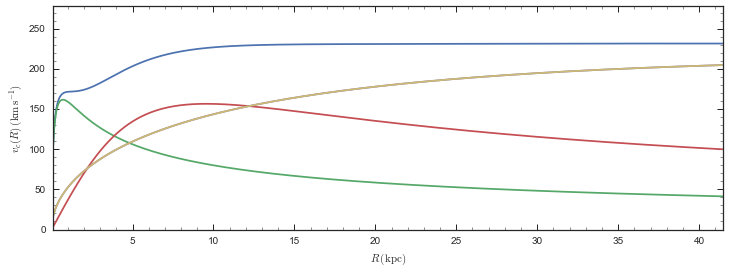

In [348]:
potential.plotRotcurve(pot)
potential.plotRotcurve(pot[0],overplot=True)
potential.plotRotcurve(pot[1],overplot=True)
potential.plotRotcurve(pot[2],overplot=True)
potential.plotRotcurve(np,overplot=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


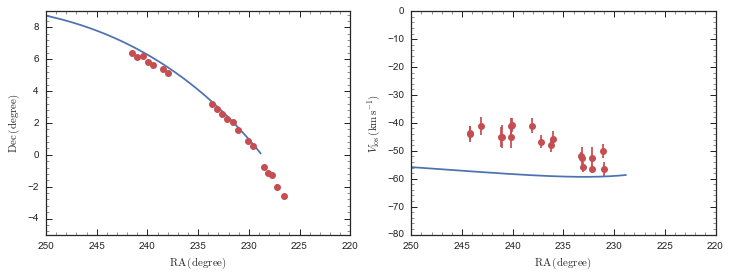

In [565]:
%pylab inline
figsize(12,4)
subplot(1,2,1)
plot(pal5varyc_like[0][0,:,0],pal5varyc_like[0][0,:,1])
subplot(1,2,2)
plot(pal5varyc_like[2][0,:,0],pal5varyc_like[2][0,:,1])
plot_data_add_labels(radeconly=False)